<a href="https://colab.research.google.com/github/elfkr7/Computer_Vision_FinalProject/blob/main/Final_Project_CV_Elif_Furkan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Computer Vision Final Project
#### Building Segmentation Through Satellite Imagery using Convolutional Neural Networks and Morphological Boundary Extraction
####  Elif KIR, M. Furkan Oruc

###### In this project, following links are used as  reference:
###### Mapping Challenge Dataset: https://www.kaggle.com/datasets/kmader/synthetic-word-ocr3. 
###### Original Competition Host: https://www.aicrowd.com/challenges/mapping-challenge4. https://github.com/neptune-ai/open-solution-mapping-challenge5. 
###### https://www.mathworks.com/discovery/image-segmentation.html#image-segmentation-with-matlab6. 
###### Mader, 2018 https://www.kaggle.com/code/kmader/segmenting-buildings-in-satellite-images/data7. 
###### https://www.kaggle.com/code/menglugeo/cnn-building-classification-from-satellite-imagery/notebook

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kmader/synthetic-word-ocr

synthetic-word-ocr.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
map_base_dir = '/content/'
map_img_dir = '/content/train/images/'

In [ ]:
!unzip -q /content/synthetic-word-ocr.zip

replace annotation-small.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
json_path = os.path.join(map_base_dir, 'annotation-small.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

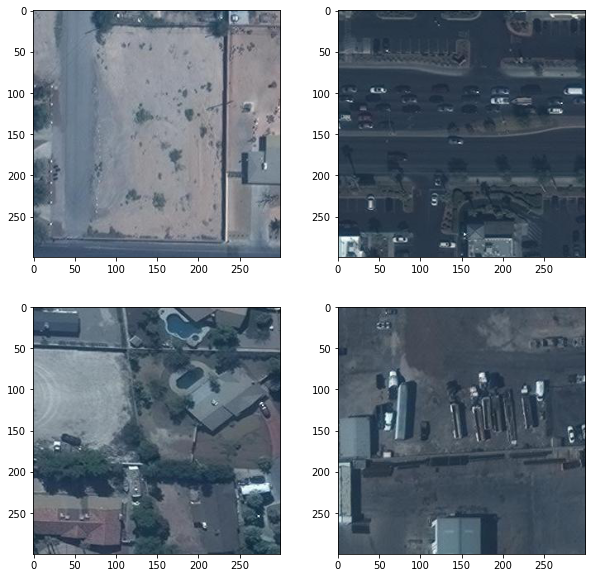

In [ ]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [ ]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

id  image_id                                       segmentation  \
39656  1855124    217607  [[288.0, 179.0, 300.0, 179.0, 300.0, 206.0, 28...   
67719  2298871    269455  [[60.0, 254.0, 60.0, 216.0, 87.0, 216.0, 87.0,...   
11823   937978    110154  [[214, 109, 214, 159, 177, 159, 177, 96, 206, ...   

         area                         bbox  category_id  iscrowd  
39656  1326.0  [179.0, 262.0, 121.0, 38.0]          100        0  
67719  1404.0    [60.0, 60.0, 194.0, 27.0]          100        0  
11823  2227.0          [109, 177, 105, 37]          100        0

In [ ]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

8366 + 71871 -> 71871


id_x  image_id                                       segmentation  \
47416  1188024    139460  [[116.0, 2.0818995585505003e-15, 116.0, 52.0, ...   
19927   148973     17557  [[174.0, 255.0, 188.0, 217.0, 248.0, 234.0, 23...   

         area                                         bbox  category_id  \
47416  1456.0  [2.0818995585505003e-15, 88.0, 116.0, 28.0]          100   
19927  2671.0                  [174.0, 174.0, 105.0, 74.0]          100   

       iscrowd    id_y         file_name  width  height  
47416        0  139460  000000139460.jpg    300     300  
19927        0   17557  000000017557.jpg    300     300

In [ ]:
def create_boxes(in_rows):
    box_list = []
    for _, in_row in in_rows.iterrows():
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

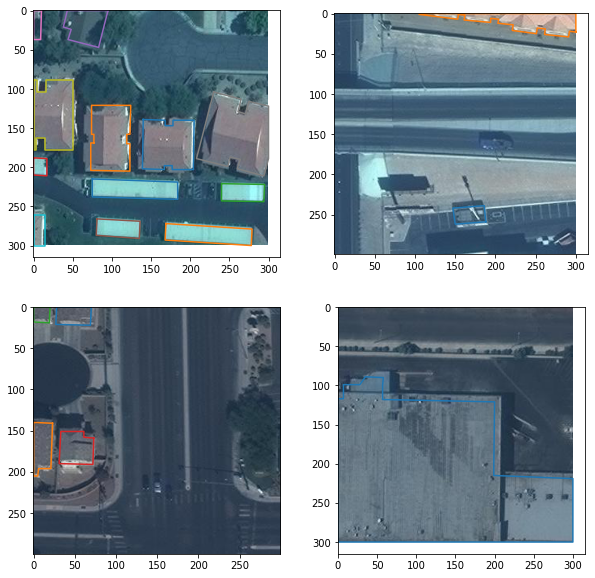

In [ ]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [ ]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

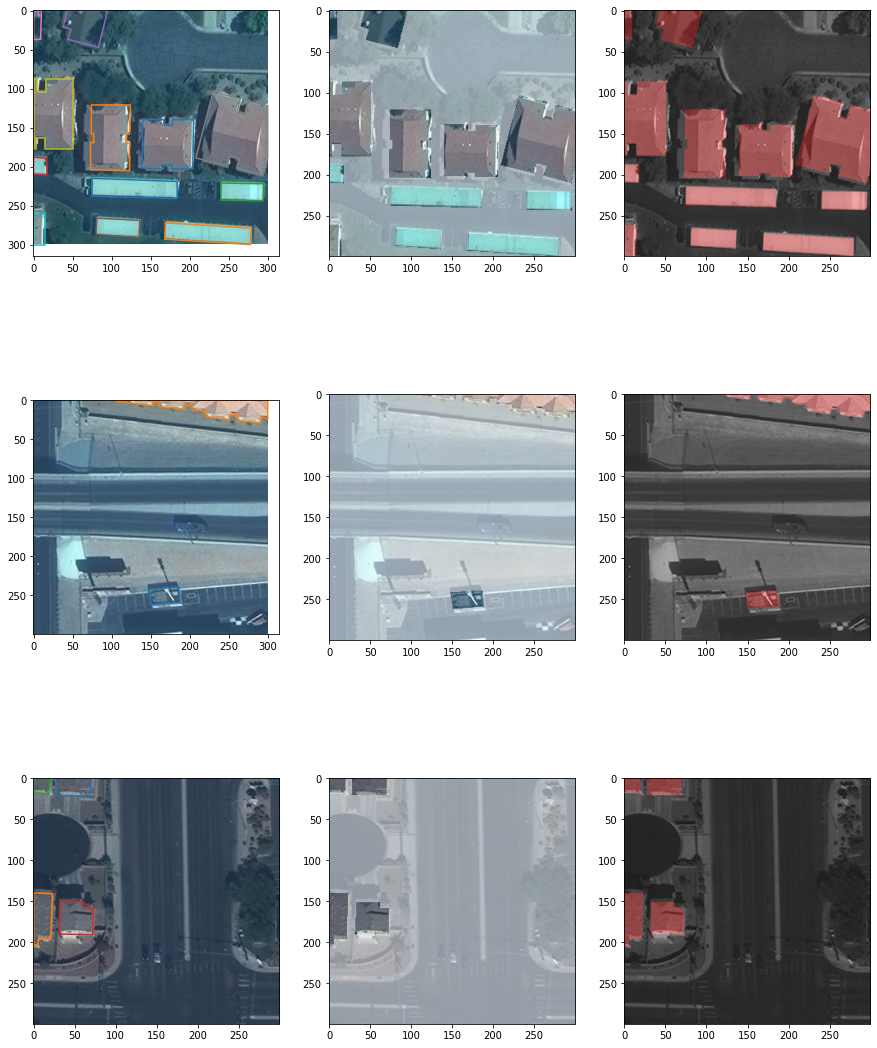

In [ ]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

53753 training boxes
18118 validation boxes


In [ ]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


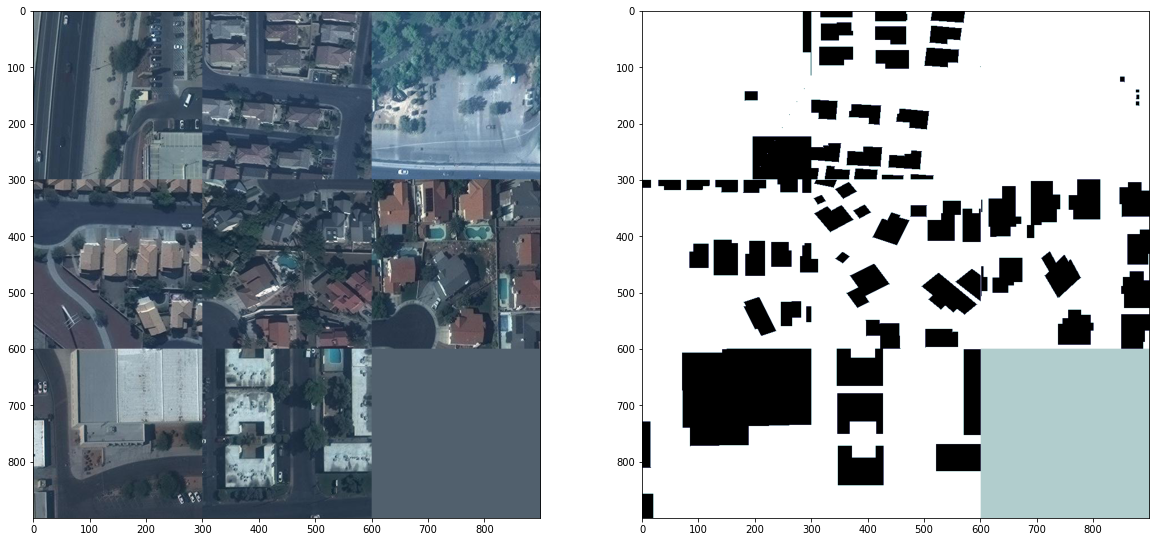

In [ ]:
from skimage.util import montage as montage2d
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')

In [ ]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 24

In [ ]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 300, 300, 3)  0          ['RGB_Input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 300, 300, 3)  12         ['gaussian_noise[0][0]']         
 alization)                                                                                       
                                                                                              

In [ ]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE), 
                             steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=4, 
                             validation_data = valid_gen,
                             validation_steps = min(train_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list,
                            workers=2, use_multiprocessing=True)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


Epoch 1/4
100/100 [==============================] - ETA: 0s - loss: -0.3525 - dice_coef: 0.4234 - binary_accuracy: 0.7106 - true_positive_rate: 0.5992

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """



Epoch 1: val_dice_coef improved from -inf to 0.41052, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 171s 2s/step - loss: -0.3525 - dice_coef: 0.4234 - binary_accuracy: 0.7106 - true_positive_rate: 0.5992 - val_loss: -0.3202 - val_dice_coef: 0.4105 - val_binary_accuracy: 0.5579 - val_true_positive_rate: 0.7732 - lr: 1.0000e-04
Epoch 2/4
100/100 [==============================] - ETA: 0s - loss: -0.3950 - dice_coef: 0.4717 - binary_accuracy: 0.7287 - true_positive_rate: 0.6535
Epoch 2: val_dice_coef improved from 0.41052 to 0.48575, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 157s 2s/step - loss: -0.3950 - dice_coef: 0.4717 - binary_accuracy: 0.7287 - true_positive_rate: 0.6535 - val_loss: -0.4069 - val_dice_coef: 0.4858 - val_binary_accuracy: 0.7089 - val_true_positive_rate: 0.6931 - lr: 1.0000e-04
Epoch 3/4
100/100 [==============================] - ETA: 0s - loss: -0.3999 - dice_coef: 0.4762 - binary_

In [ ]:
#!cat /var/log/colab-jupyter.log

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('full_best_model.h5')

x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0


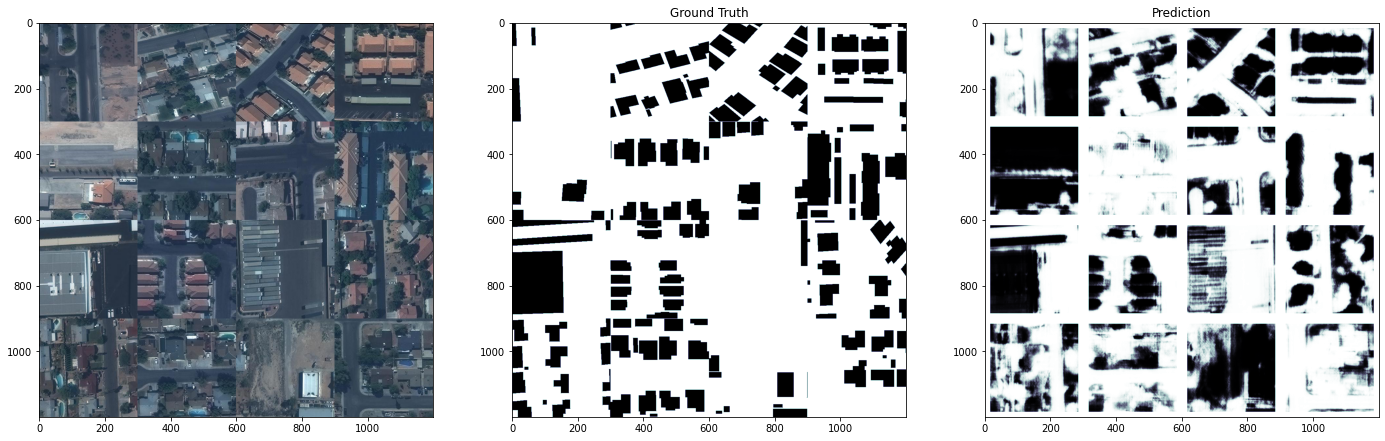

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)

x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0


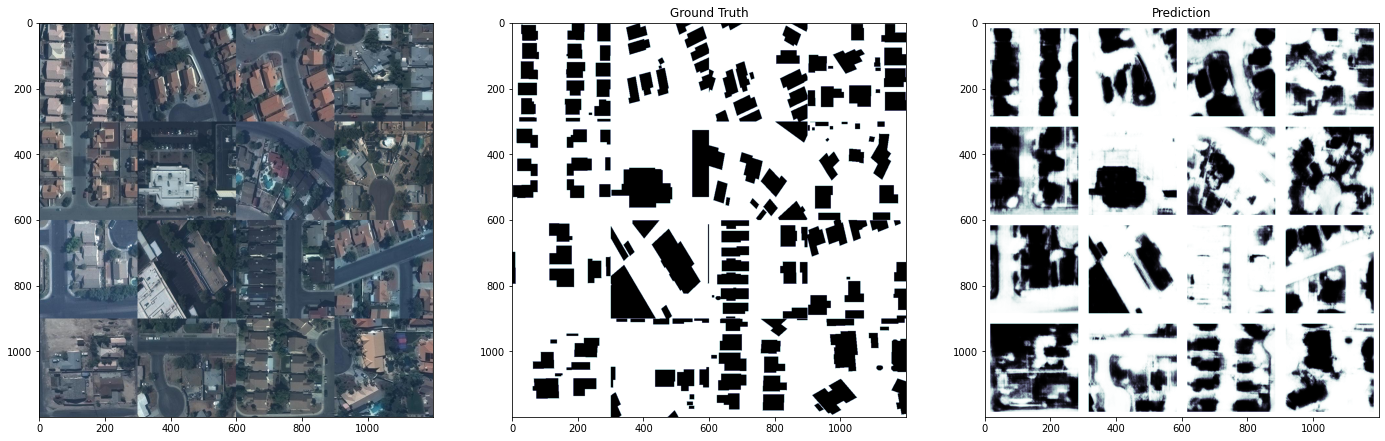

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)

x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0


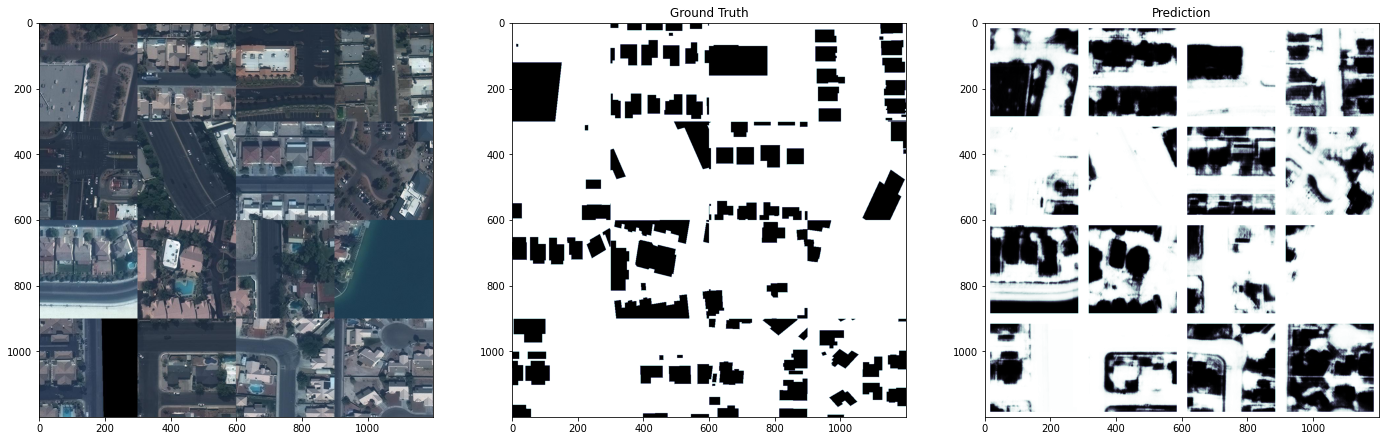

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)

x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0


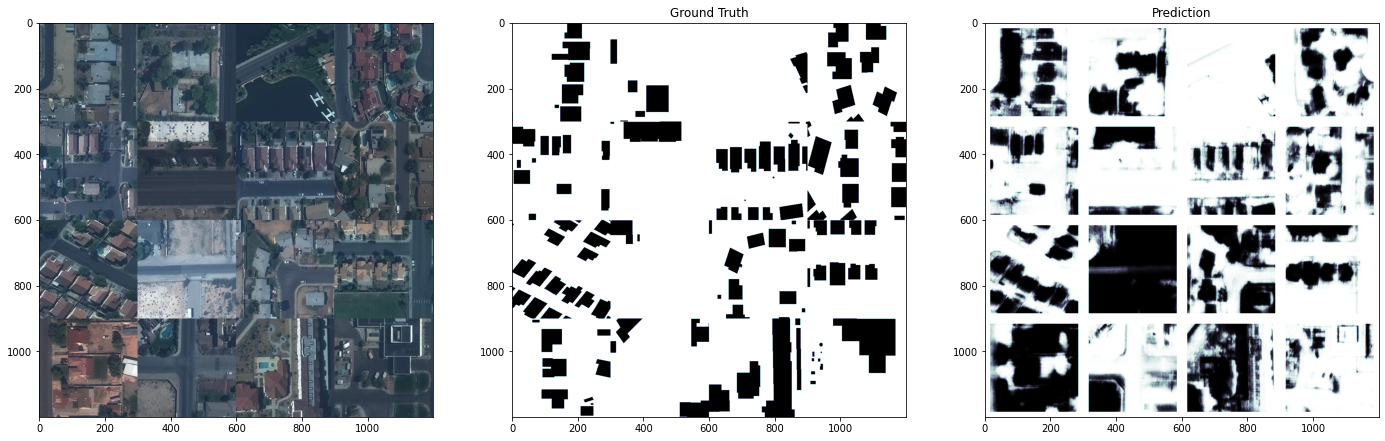

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)

x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0


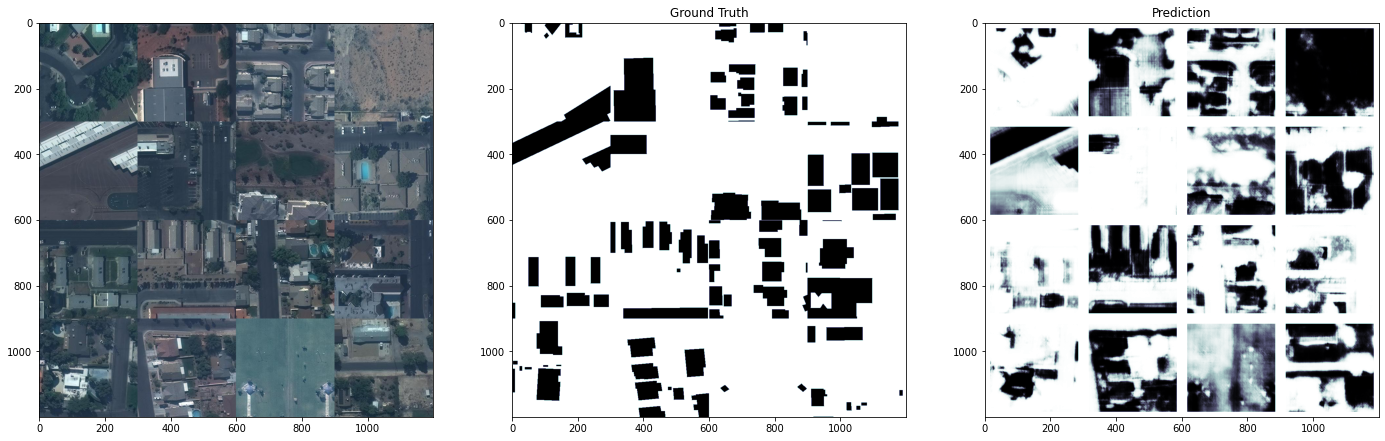

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)